In [1]:
import sys
sys.path.append("../../helper")
from AnalysisHelper import helper

from datetime import datetime as dt
from datetime import timedelta
from pandas import read_excel, to_datetime
from matplotlib import pyplot as plt
from matplotlib import dates as mdates
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima
import seaborn as sb

# 시계열 분석 연습문제
## 문제 1
다음의 데이터는 1937년 07월 01일부터 2023년 08월 06일까지 서울의 평균 기온을 조사한 자료의 일부이다.


|날짜	|평균기온(℃)|
|---|---|
1973-07-01	|22.7
1973-07-02	|23.8
1973-07-03	|27.2
1973-07-04|	25.2
1973-07-05|	26.9

이 데이터를 활용하여 조사기간동안 서울의 평균기온이 어떻게 변화하고 있는지 ARIMA와 AUTO_ARIMA를 사용하여 분석하고 앞으로 1년간의 평균 기온을 시각화 하시오.

시각화 기간은 2023년 8월 6일을 기준으로 전후 1년간으로 한다.

In [2]:
df =read_excel("https://data.hossam.kr/E06/temperatures_seoul.xlsx")
df.head()

,날짜,평균기온(℃)
0,1973-07-01,22.7
1,1973-07-02,23.8
2,1973-07-03,27.2
3,1973-07-04,25.2
4,1973-07-05,26.9


결측치 확인

In [3]:
df.isna().sum()

날짜         0
평균기온(℃)    0
dtype: int64

In [4]:
df2 = helper.set_datetime_index(df,'날짜')
df2.head()
df2.rename(columns={'평균기온(℃)':"Temperature"},inplace=True)

데이터 검정

결측치 수: 0


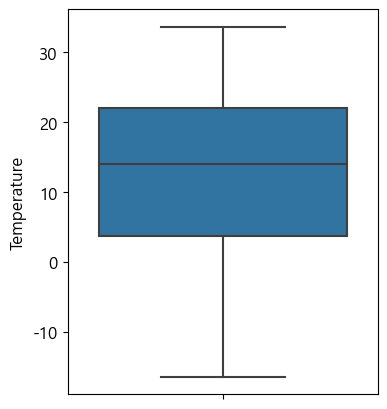

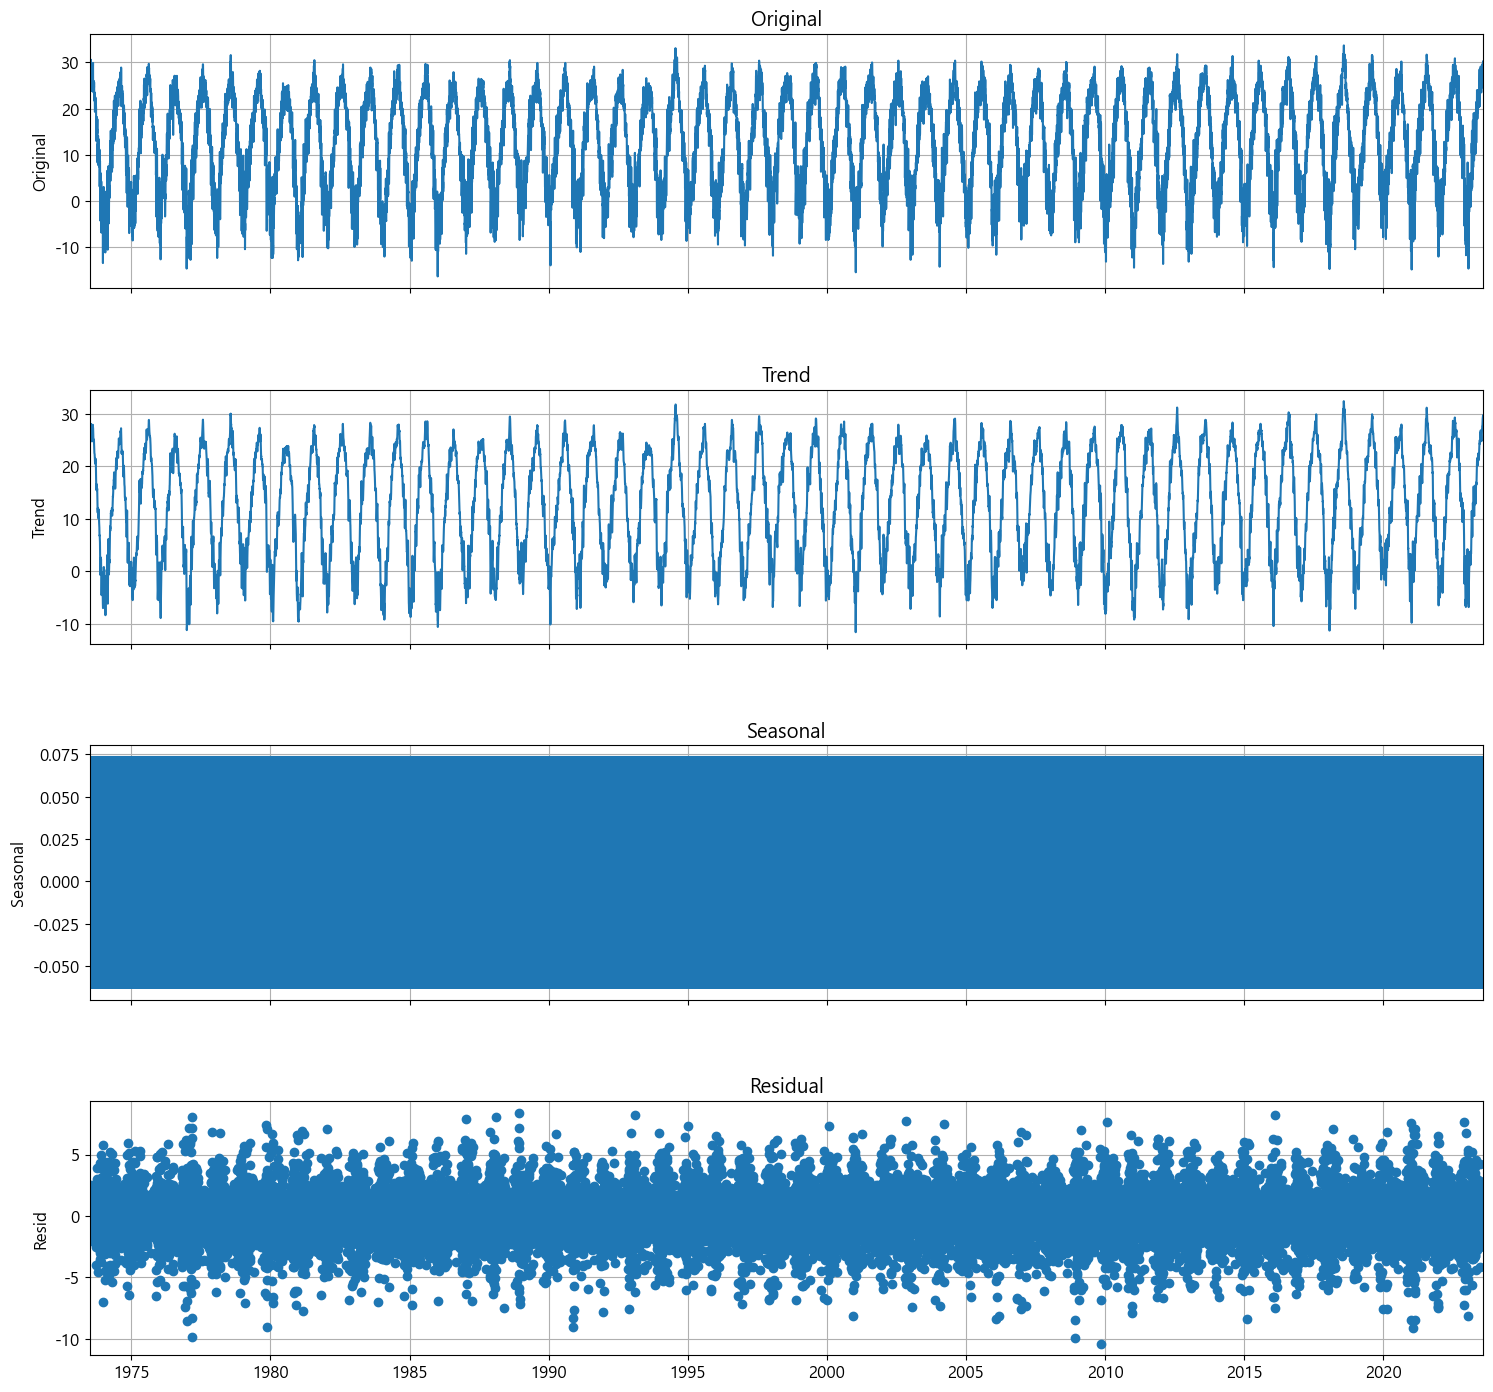

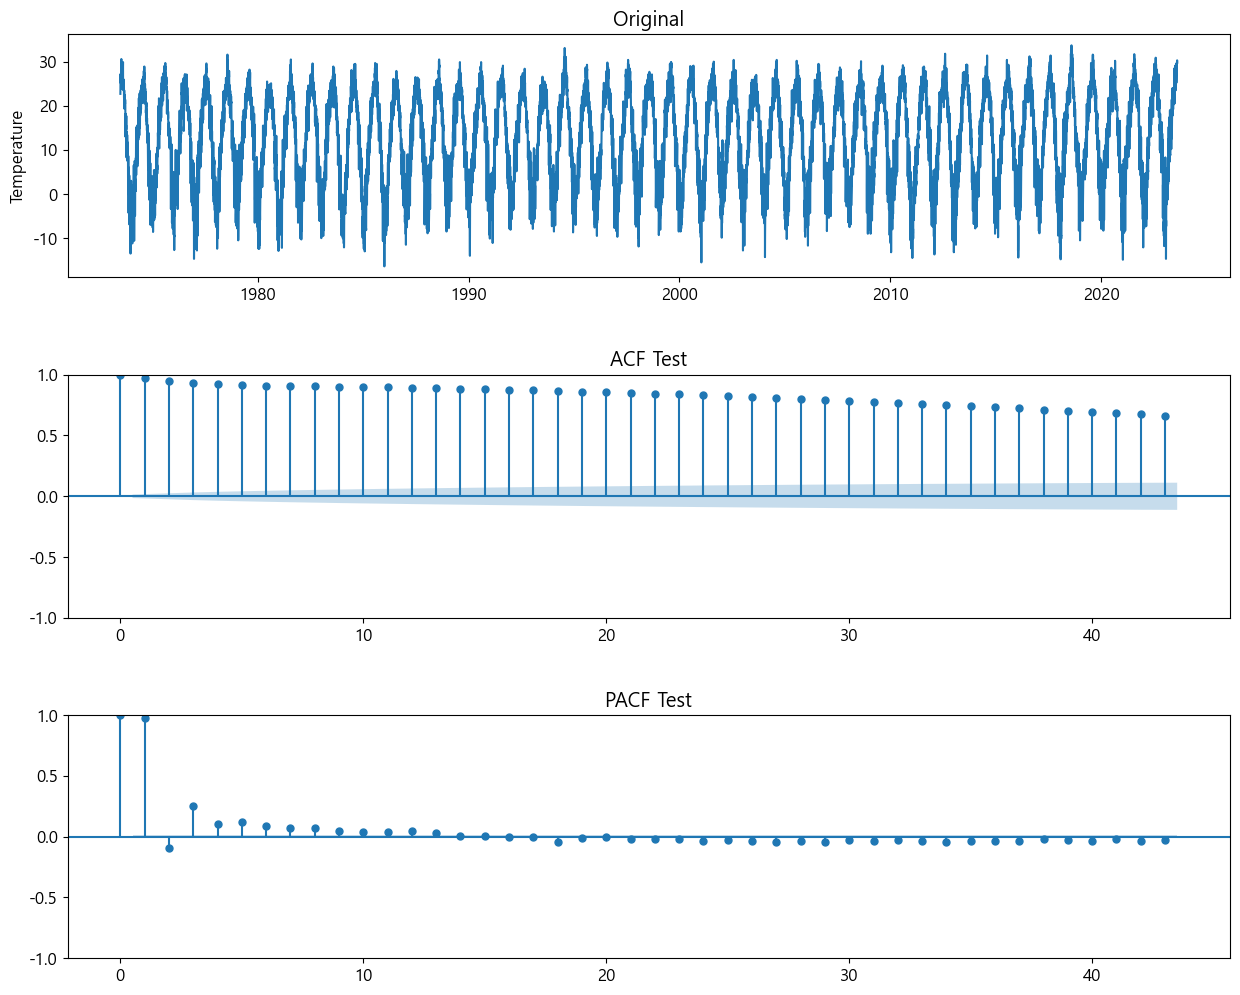

=========== 원본 데이터 ===========
+------------------------------------+-------------+
| ADF Test                           |             |
|------------------------------------+-------------|
| 검정통계량(ADF Statistic)          |    -13.6504 |
| 유의수준(p-value)                  | 1.58975e-25 |
| 최적차수(num of lags)              |          45 |
| 관측치 개수(num of observations)   |       18253 |
| 기각값(Critical Values) 1%         |    -3.43071 |
| 기각값(Critical Values) 5%         |     -2.8617 |
| 기각값(Critical Values) 10%        |    -2.56685 |
| 데이터 정상성 여부(0=Flase,1=True) |           1 |
+------------------------------------+-------------+


In [5]:
helper.exp_time_data(data=df2, yname='Temperature', sd_model='a')

ADF 테스트의 $p-value$가 유의수준의 $p-value = 0.05$보다 작기 때문에 귀무가설인 정상성을 따르지 않는다를 기각하고 정상성을 따른다는 충분한 증거를 찾았다고 볼 수 있다. 그러나 ACF가 0으로 수렵하지 않기때문에 계절성을 의심해 볼 수 있다.

In [6]:
model = ARIMA(df2['Temperature'], order=(4,0,0), seasonal_order=(4,0,0,12))
fit = model.fit()
print(fit.summary())
# my_p = 4    # AR의 차수 (검증한 결과를 활용)
# my_d = 0    # 차분 횟수 (검증한 결과를 활용)
# my_q = 0    # MA의 차수 (검증한 결과를 활용)
# my_s = 12    # 계절성 주기 (분석가가 판단)

# model = auto_arima(
#     y=df2['Temperature'],  # 모델링하려는 시계열 데이터 또는 배열
#     start_p=0,           # p의 시작점
#     max_p=my_p,          # p의 최대값
#     d=my_d,              # 차분 횟수
#     start_q=0,           # q의 시작점
#     max_q=my_q,          # q의 최대값
#     seasonal=True,       # 계절성 사용 여부
#     m=my_s,              # 계절성 주기
#     start_P=0,           # P의 시작점
#     max_P=my_p,          # P의 최대값
#     D=my_d,              # 계절성 차분 횟수
#     start_Q=0,           # Q의 시작점
#     max_Q=my_q,          # Q의 최대값
#     trace=True           # 학습 과정 표시 여부
# )
# print(model.summary())

KeyboardInterrupt: 

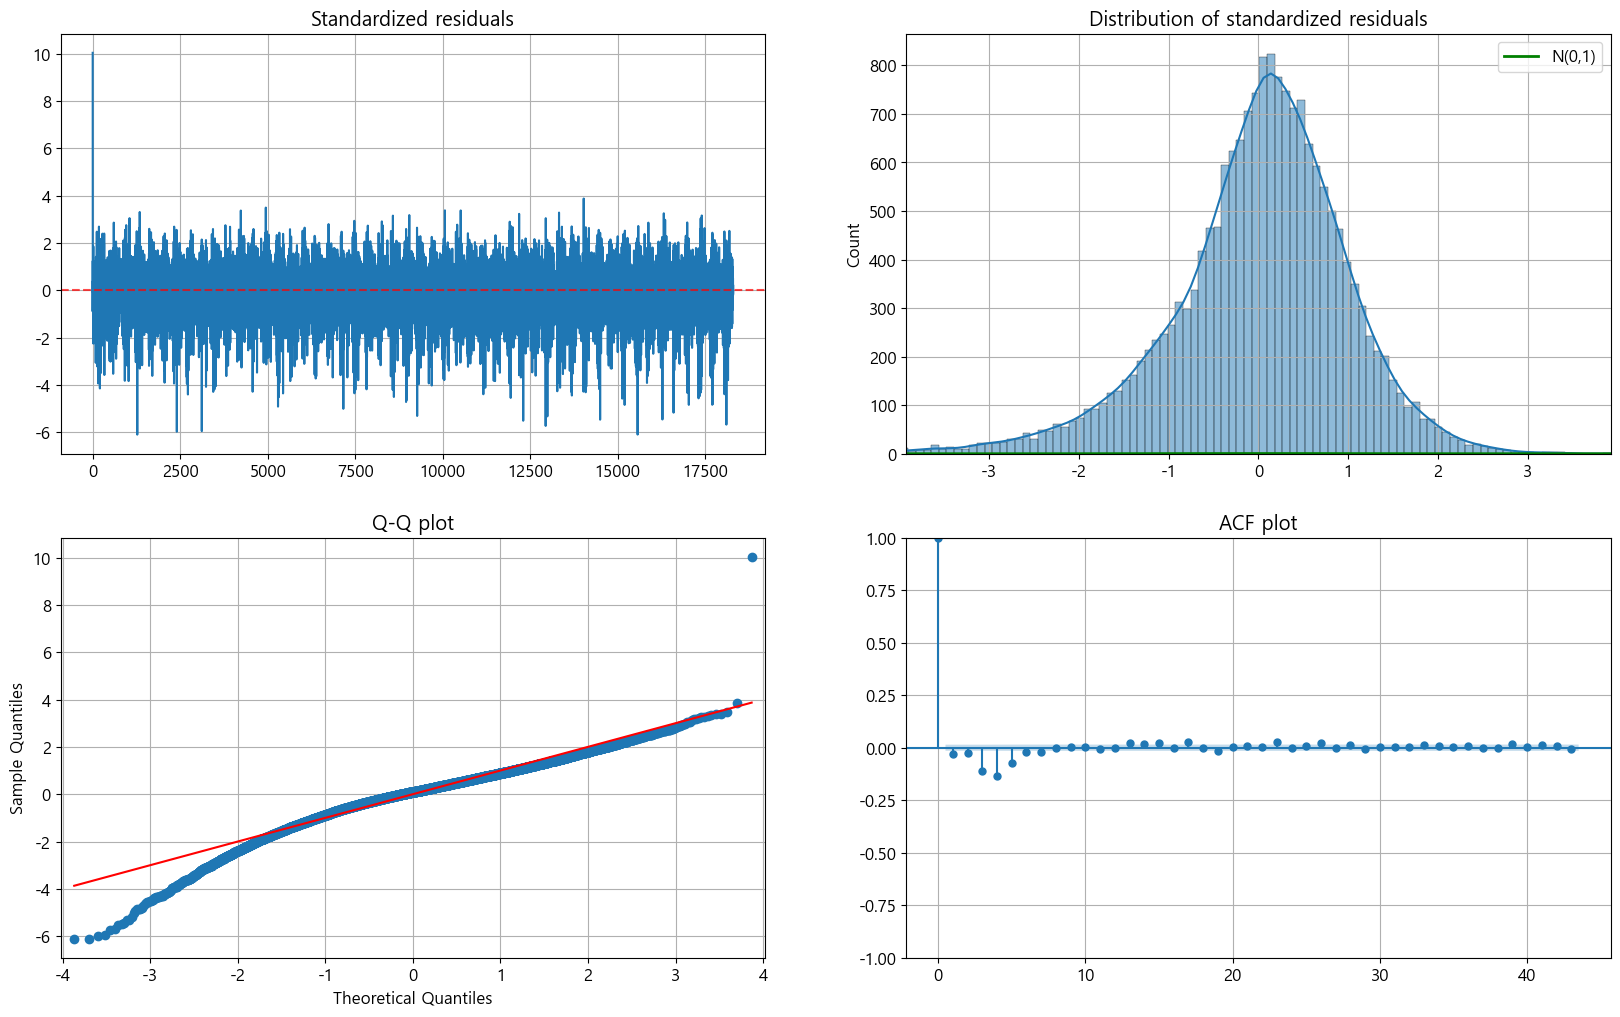

In [ ]:
helper.arima_diagnostics(fit.resid)


In [ ]:
fv = fit.fittedvalues
fv.head()

1973-07-01     0.000000
1973-07-02    22.700010
1973-07-03    23.888722
1973-07-04    27.255968
1973-07-05    24.096742
Freq: D, dtype: float64

In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_error
actual_data = df2['Temperature']
fitted_values = fv

In [ ]:
mse = mean_squared_error(actual_data, fitted_values)
mse

5.121326005056729

In [ ]:
fc = fit.forecast(365)
fc

2023-08-07    29.670415
2023-08-08    29.785627
2023-08-09    29.829962
2023-08-10    29.816001
2023-08-11    29.797881
                ...    
2024-08-01    29.867848
2024-08-02    29.867848
2024-08-03    29.867848
2024-08-04    29.867848
2024-08-05    29.867848
Freq: D, Name: predicted_mean, Length: 365, dtype: float64

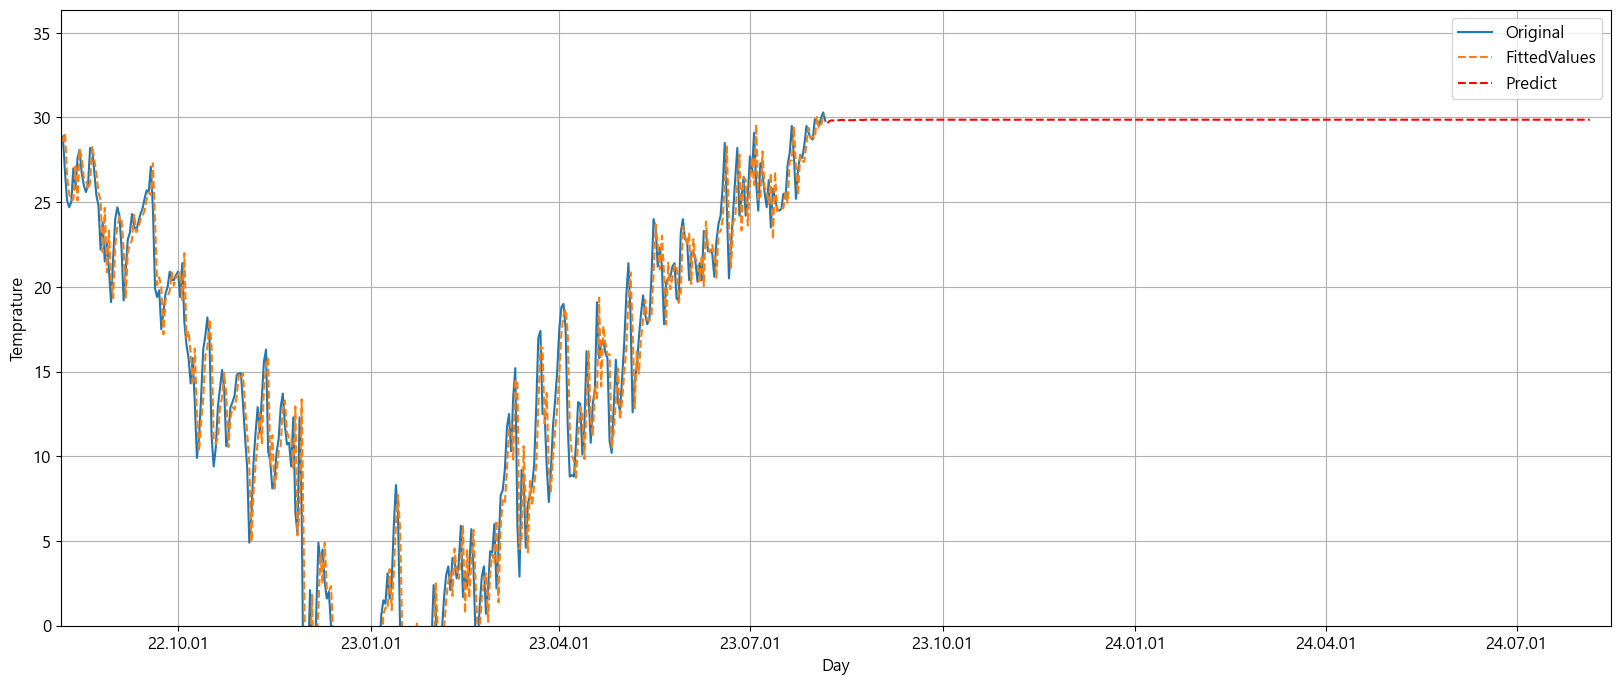

In [ ]:
plt.figure(figsize=(20,8))

# 원본 데이터
sb.lineplot(data=df2, x=df2.index, y='Temperature', label='Original')

# 원본에 대한 학습결과
sb.lineplot(x=fv.index, y=fv.values, label='FittedValues', linestyle='--')

# 뒤 30% + 10단계에 대한 예측 데이터
sb.lineplot(x=fc.index, y=fc.values, label='Predict', linestyle='--', color='red')

plt.xlabel('Day')
plt.ylabel('Temprature')
plt.legend()

last = df2.index.max()
xmin = last-timedelta(days=365)
xmax = last+timedelta(days=365+10)
ymax = df2['Temperature'][xmin:xmax].max()

plt.xlim([xmin, xmax])
plt.ylim([0, ymax*1.2])

# 그래프의 x축이 날짜로 구성되어 있을 경우 형식 지정
monthyearFmt = mdates.DateFormatter('%y.%m.%d')
plt.gca().xaxis.set_major_formatter(monthyearFmt)

plt.grid()
plt.show()
plt.close()


다음의 데이터는 1981년 01월부터 2023년 05월까지 전국에서 출생한 신생아 수를 조사하여 시,도별로 표시한 자료의 일부이다.

|시점	|서울특별시|	부산광역시	|대구광역시	|인천광역시|
|---|---|---|---|---|
|1981년 |01월	|21,461	|7,846|	3,547|	2,886
1981년| 02월|	23,389|	8,622|3,588	|3,044
1981년 |03월|	15,042|	6,284|	2,885|	2,456
1981년 |04월|	15,231|	5,806|	2,783|	2,369
1981년 |05월|	16,239|	6,225|	2,808|	2,468

이 데이터를 활용하여 조사기간동안 전국에서 태어난 신생아 수가 어떻게 변화하고 있는지 ARIMA와 AUTO_ARIMA중 자신이 사용 가능한 방식 하나를 선정하여 분석하고 앞으로 5년간의 신생아 수를 예측한 자료를 시각화 하시오.

단, 조사되지 않은 항목에 대해서는 신생아수가 0인 것으로 간주한다.



In [7]:
birth = read_excel("https://data.hossam.kr/E06/newborn.xlsx")
birth

,시점,서울특별시,부산광역시,대구광역시,인천광역시,광주광역시,대전광역시,울산광역시,세종특별자치시,경기도,강원도,충청북도,충청남도,전라북도,전라남도,경상북도,경상남도,제주특별자치도
0,1981년 01월,21461,7846,3547,2886,NaN,NaN,NaN,NaN,9685,3729,3002,6293,4956,8741,7454,7501,1050
1,1981년 02월,23389,8622,3588,3044,NaN,NaN,NaN,NaN,10352,3637,3161,7761,5326,8319,7446,8039,872
2,1981년 03월,15042,6284,2885,2456,NaN,NaN,NaN,NaN,7727,3158,2486,5214,3855,7566,6229,6714,805
3,1981년 04월,15231,5806,2783,2369,NaN,NaN,NaN,NaN,7321,3166,2230,4621,3634,6553,5548,6079,752
4,1981년 05월,16239,6225,2808,2468,NaN,NaN,NaN,NaN,7823,3234,2419,4879,3709,6564,5529,6222,821
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
504,2023년 01월,4079,1303,905,1428,626.0,675.0,519.0,313.0,6957,675,698,921,687,780,1041,1230,345
505,2023년 02월,3284,1130,801,1187,588.0,650.0,436.0,278.0,5979,602,636,805,539,671,942,1139,272
506,2023년 03월,3605,1170,905,1219,572.0,658.0,489.0,255.0,6306,640,725,826,589,714,923,1256,286
507,2023년 04월,3062,1059,719,1061,490.0,599.0,418.0,236.0,5657,545,638,763,518,622,825,1007,266


#### 데이터 타입 확인

In [8]:
birth.dtypes

시점          object
서울특별시        int64
부산광역시        int64
대구광역시        int64
인천광역시        int64
광주광역시      float64
대전광역시      float64
울산광역시      float64
세종특별자치시    float64
경기도          int64
강원도          int64
충청북도         int64
충청남도         int64
전라북도         int64
전라남도         int64
경상북도         int64
경상남도         int64
제주특별자치도      int64
dtype: object

#### 날짜 컬럼에 대한 타입 설정

In [9]:
birth['시점'] = to_datetime(birth['시점'], format= "%Y년  %m월")
birth.dtypes

시점         datetime64[ns]
서울특별시               int64
부산광역시               int64
대구광역시               int64
인천광역시               int64
광주광역시             float64
대전광역시             float64
울산광역시             float64
세종특별자치시           float64
경기도                 int64
강원도                 int64
충청북도                int64
충청남도                int64
전라북도                int64
전라남도                int64
경상북도                int64
경상남도                int64
제주특별자치도             int64
dtype: object

#### 날짜 형식의 인덱스 설정

In [10]:
df = set_datetime_index(birth,'시점')
df

NameError: name 'set_datetime_index' is not defined

#### 결측치 검사

In [11]:
df.isna().sum()

날짜         0
평균기온(℃)    0
dtype: int64

#### 결측치 정제
모두 0으로 설정

In [12]:
df2 = df.fillna(0)
df2.head()

,날짜,평균기온(℃)
0,1973-07-01,22.7
1,1973-07-02,23.8
2,1973-07-03,27.2
3,1973-07-04,25.2
4,1973-07-05,26.9


#### 전국에 대한 파생변수 생성

In [ ]:
df2['전국'] = df2.sum(axis=1)
df2.head()

#### 데이터 검정

In [ ]:
exp_time_data(data=df2, yname="전국", sd_model="m", max_diff=10)

#### ARIMA 분석
##### 분석 모델 만들기

In [ ]:
model =ARIMA(df2['전국'], order=(1,1,0), seasonal_order=(1,1,0,12))
fit = model.fit()
print(fit.summary())

#### 학습 모델에 대한 예측치

In [ ]:
fv = fit.fittedvalues
fv.head()

#### 학습한 내용을 토대로 1년간의 예상치 생성

In [ ]:
fc = fit.forecast(365)
fc.head()

#### 시각화

In [ ]:
last = df2.index.max()
xmin = last-timedelta(days=365)
xmax = last+timedelta(days=365+10)
ymax = df2['전국'][xmin:xmax].max()
ymin = df2['전국'][xmin:xmax].min()
xmin, xmax, ymax, ymin